# Predicting Carbon Emissions in Rwanda

#### Importing Libraries

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta
import missingno as msno

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

#### Importing Datasets

In [238]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#### Data Exploration

In [239]:
display(df_train.head())

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

In [240]:
df_train.shape

(79023, 76)

In [241]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

<Axes: >

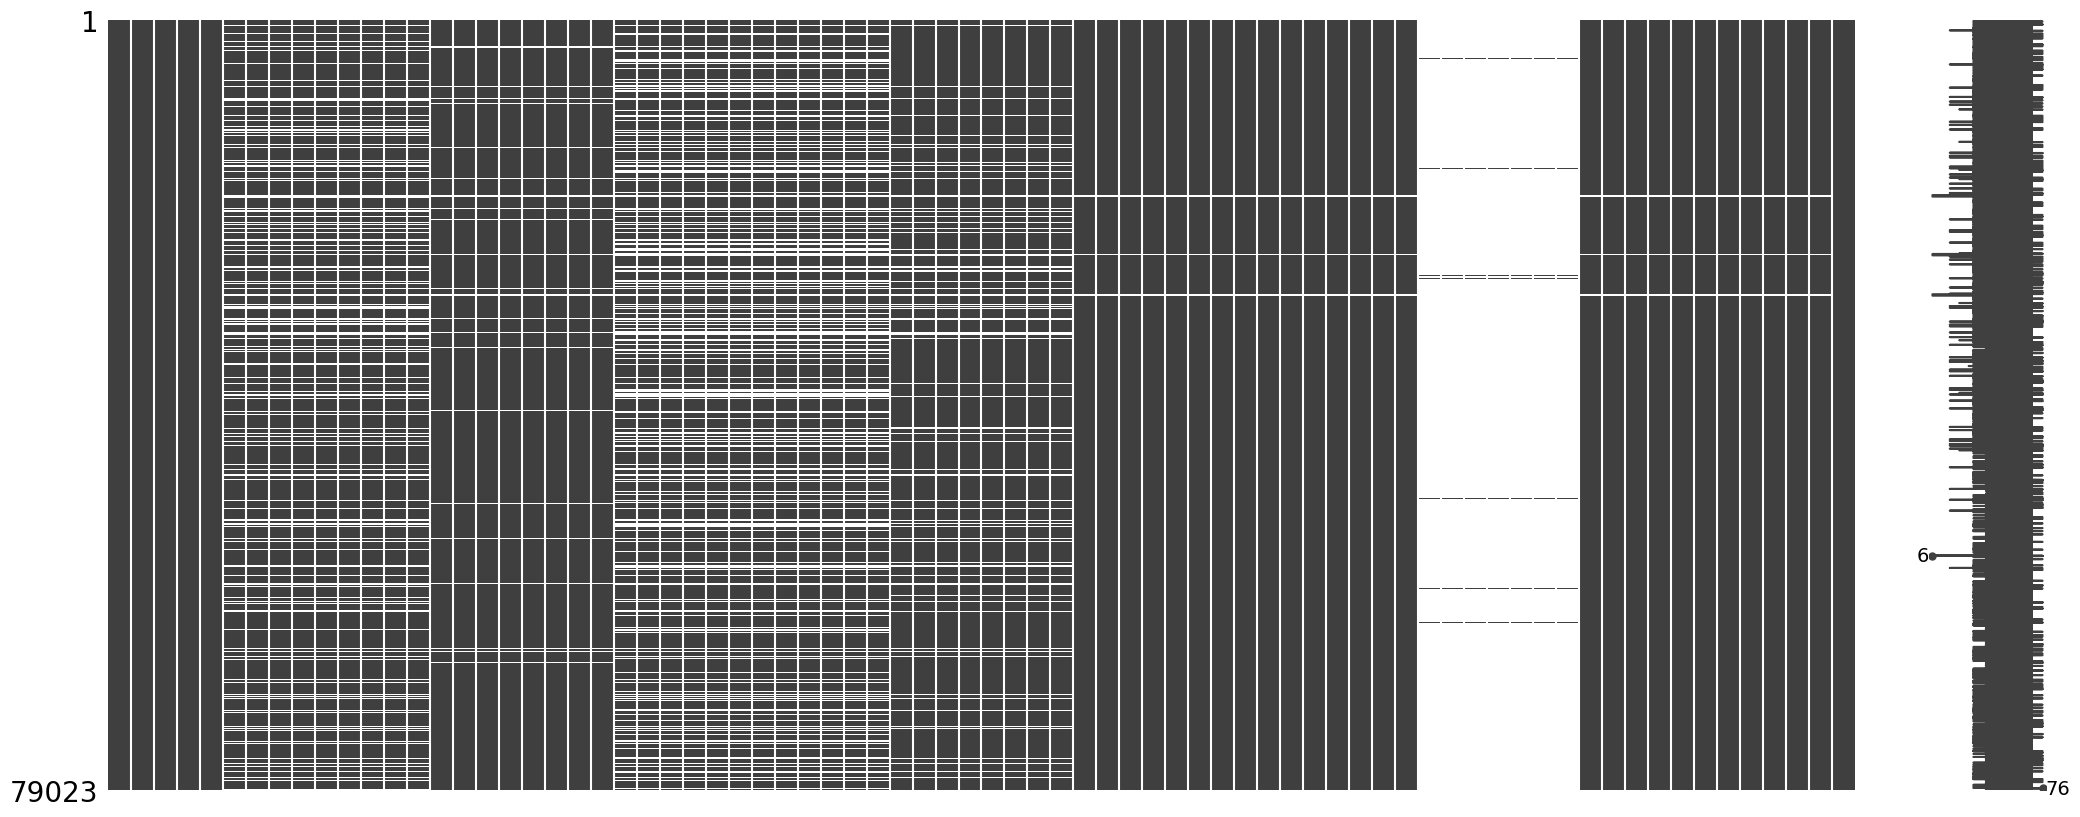

In [242]:
msno.matrix(df_train)

In [243]:
# Selecting a subset of features that may have an impact on carbon emissions for in-depth exploratory data analysis.
df_filtered = df_train[['ID_LAT_LON_YEAR_WEEK', 
                        'latitude', 
                        'longitude', 
                        'year', 
                        'week_no', 
                        'SulphurDioxide_SO2_column_number_density', 
                        'CarbonMonoxide_CO_column_number_density',
                        'CarbonMonoxide_H2O_column_number_density', 
                        'NitrogenDioxide_NO2_column_number_density',  
                        'Formaldehyde_tropospheric_HCHO_column_number_density', 
                        'UvAerosolIndex_absorbing_aerosol_index', 
                        'Ozone_O3_column_number_density', 
                        'Cloud_cloud_fraction', 
                        'emission']]

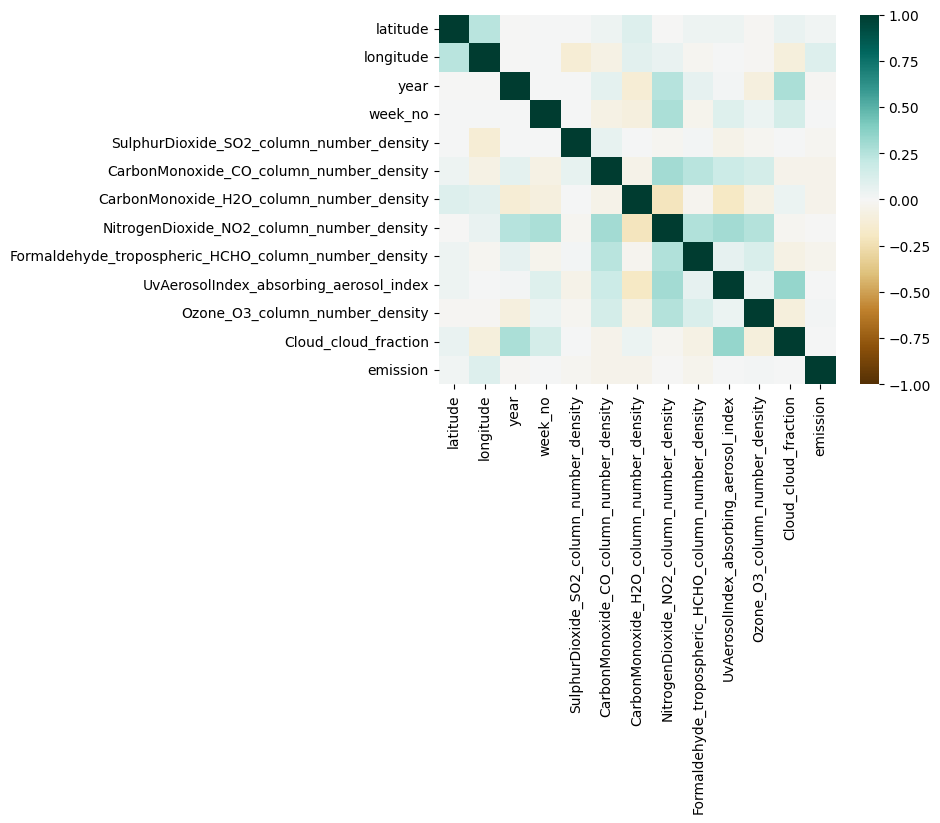

In [244]:
# Plotting Correlation Matrix
corr_matrix = df_filtered.corr(numeric_only=True)
sn.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap = 'BrBG')
plt.show()

At a glance, there appears to be very little correlation between carbon emissions and any other types of emissions

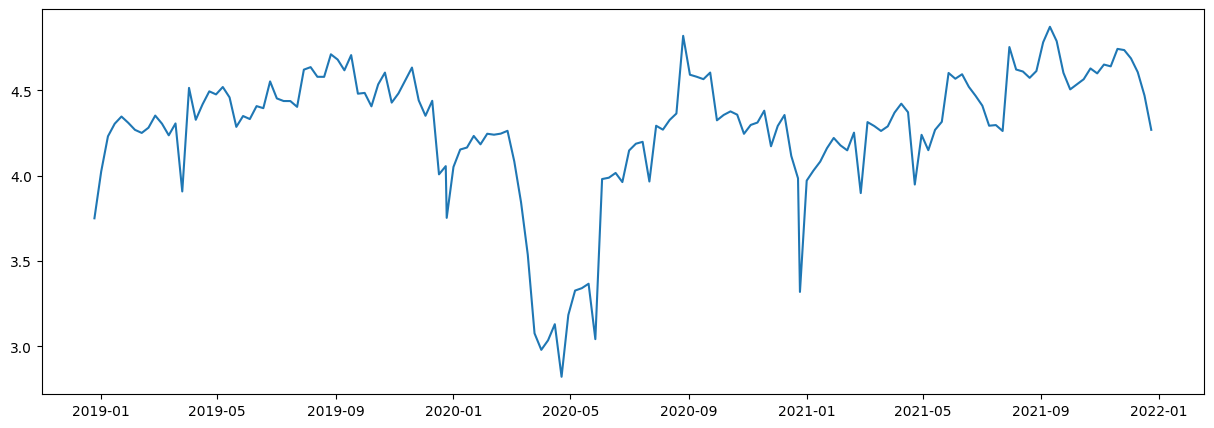

In [245]:
# Adding dates
def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)

df_filtered['date'] =  df_filtered.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

# Getting unique pairs for longitude and latitude
unique_lon_lats = df_filtered[['longitude', 
                               'latitude']].drop_duplicates()

# First test location
long = unique_lon_lats.iloc[0, 0]
lat = unique_lon_lats.iloc[0, 1]

df_one_location = df_filtered.query("longitude == @long and latitude == @lat")

# Ploting carbon emissions over time
plt.figure(figsize = (15, 5))
plt.plot(df_one_location['date'], df_one_location['emission'])
plt.show()

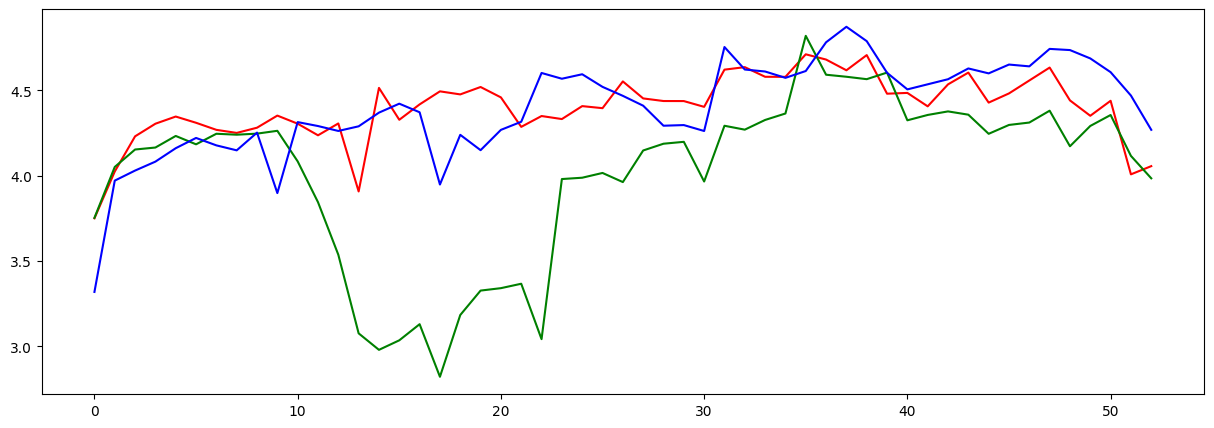

In [246]:
# Plotting emissions over week_no
df_2019 = df_one_location.query("year == 2019")
df_2020 = df_one_location.query("year == 2020")
df_2021 = df_one_location.query("year == 2021")

plt.figure(figsize = (15, 5))
plt.plot(df_2019['week_no'], df_2019['emission'], color = 'red')
plt.plot(df_2020['week_no'], df_2020['emission'], color = 'green')
plt.plot(df_2021['week_no'], df_2021['emission'], color = 'blue')
plt.show()

Excluding mid 2020, carbon emissions seem to follow an annual pattern with some variation from week to week. There aren't any other obvious patterns.
We will deal with covid data later.

#### Feature Engineering

In [247]:
# Grouping data by longitude & latitude
df_grouped = df_filtered.groupby(['longitude', 'latitude'])
lst = []
for name, group_df in df_grouped:

    # Creating rolling carbon emission averages with different window sizes
    group_df['rolling_emission3'] = group_df['emission'].rolling(window = 3, center = True).mean()
    group_df['rolling_emission5'] = group_df['emission'].rolling(window = 5, center = True).mean()
    group_df['rolling_emission7'] = group_df['emission'].rolling(window = 7, center = True).mean()
    group_df['rolling_emission9'] = group_df['emission'].rolling(window = 9, center = True).mean()

    # Creating rolling averages for other emissions with the highest correlation to carbon emissions
    group_df['rolling_SulphurDioxide_SO2_column_number_density'] = group_df['SulphurDioxide_SO2_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_CarbonMonoxide_CO_column_number_density'] = group_df['CarbonMonoxide_CO_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_NitrogenDioxide_NO2_column_number_density'] = group_df['NitrogenDioxide_NO2_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_Formaldehyde_tropospheric_HCHO_column_number_density'] = group_df['Formaldehyde_tropospheric_HCHO_column_number_density'].rolling(window = 3, center = True).mean()

   # Removing columns that can't be interpolated
    group_df = group_df.drop(['date', 'ID_LAT_LON_YEAR_WEEK'], axis= 1)

    # Filling missing values with interpolation
    group_df = group_df.interpolate(method = 'linear', limit_direction='both')

    lst.append(group_df)

# Bringing dataframe back together
df_new_features = pd.concat(lst)

# Creating dataframe shifted 52 weeks back
last_year_df = (df_new_features
                .assign(year = df_new_features['year'] + 1)
                .rename(columns={'emission': 'last_year_emission'
                                 , 'rolling_emission3': 'ly_rolling_emission3'
                                 , 'rolling_emission5': 'ly_rolling_emission5'
                                 , 'rolling_emission7': 'ly_rolling_emission7'
                                 , 'rolling_emission9': 'ly_rolling_emission9'
                                 , 'rolling_SulphurDioxide_SO2_column_number_density' : 'ly_rolling_SulphurDioxide_SO2_column_number_density'
                                 , 'rolling_CarbonMonoxide_CO_column_number_density': 'ly_rolling_CarbonMonoxide_CO_column_number_density'
                                 , 'rolling_NitrogenDioxide_NO2_column_number_density': 'ly_rolling_NitrogenDioxide_NO2_column_number_density'
                                 , 'rolling_Formaldehyde_tropospheric_HCHO_column_number_density': 'ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density'}))

# Joining dataframes together
df_new_features = pd.merge(df_new_features, last_year_df, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')

# Adding date back in
df_new_features['date'] = df_new_features.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)

# Creating differences between previous year emissions and current year emissions for all except carbon emissions
df_new_features['rolling_SulphurDioxide_SO2_column_number_density_difference'] = df_new_features['rolling_SulphurDioxide_SO2_column_number_density'] - df_new_features['ly_rolling_SulphurDioxide_SO2_column_number_density']
df_new_features['rolling_CarbonMonoxide_CO_column_number_density_difference'] = df_new_features['rolling_CarbonMonoxide_CO_column_number_density'] - df_new_features['ly_rolling_CarbonMonoxide_CO_column_number_density']
df_new_features['rolling_NitrogenDioxide_NO2_column_number_density_difference'] = df_new_features['rolling_NitrogenDioxide_NO2_column_number_density'] - df_new_features['ly_rolling_NitrogenDioxide_NO2_column_number_density']
df_new_features['rolling_Formaldehyde_tropospheric_HCHO_column_number_density_difference'] = df_new_features['rolling_Formaldehyde_tropospheric_HCHO_column_number_density'] - df_new_features['ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density']

# Selecting relavent columns
df_new_features = df_new_features.loc[:, ['week_no'
                                    , 'date'
                                    , 'last_year_emission'
                                    , 'ly_rolling_emission3'
                                    , 'ly_rolling_emission5'
                                    , 'ly_rolling_emission7'
                                    , 'ly_rolling_emission9'
                                    , 'ly_rolling_SulphurDioxide_SO2_column_number_density'
                                    , 'ly_rolling_CarbonMonoxide_CO_column_number_density'
                                    , 'ly_rolling_NitrogenDioxide_NO2_column_number_density'
                                    , 'ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density'
                                    , 'rolling_SulphurDioxide_SO2_column_number_density_difference'
                                    , 'rolling_CarbonMonoxide_CO_column_number_density_difference'
                                    , 'rolling_NitrogenDioxide_NO2_column_number_density_difference'
                                    , 'rolling_Formaldehyde_tropospheric_HCHO_column_number_density_difference'
                                    , 'emission']]

In [248]:
# Excluding covid data
date_start = datetime(2020, 3, 1)
date_end = datetime(2020, 9, 30)
df_new_features = (df_new_features
                .query("date < @date_start or date > @date_end"))

# Excluding data with features affected by covid
date_start = datetime(2021, 3, 1)
date_end = datetime(2021, 9, 30)
df_new_features = (df_new_features
                .query("date < @date_start or date > @date_end"))

# Removing rows without previous year data (2019)
df_new_features = df_new_features[df_new_features['last_year_emission'].notnull()]

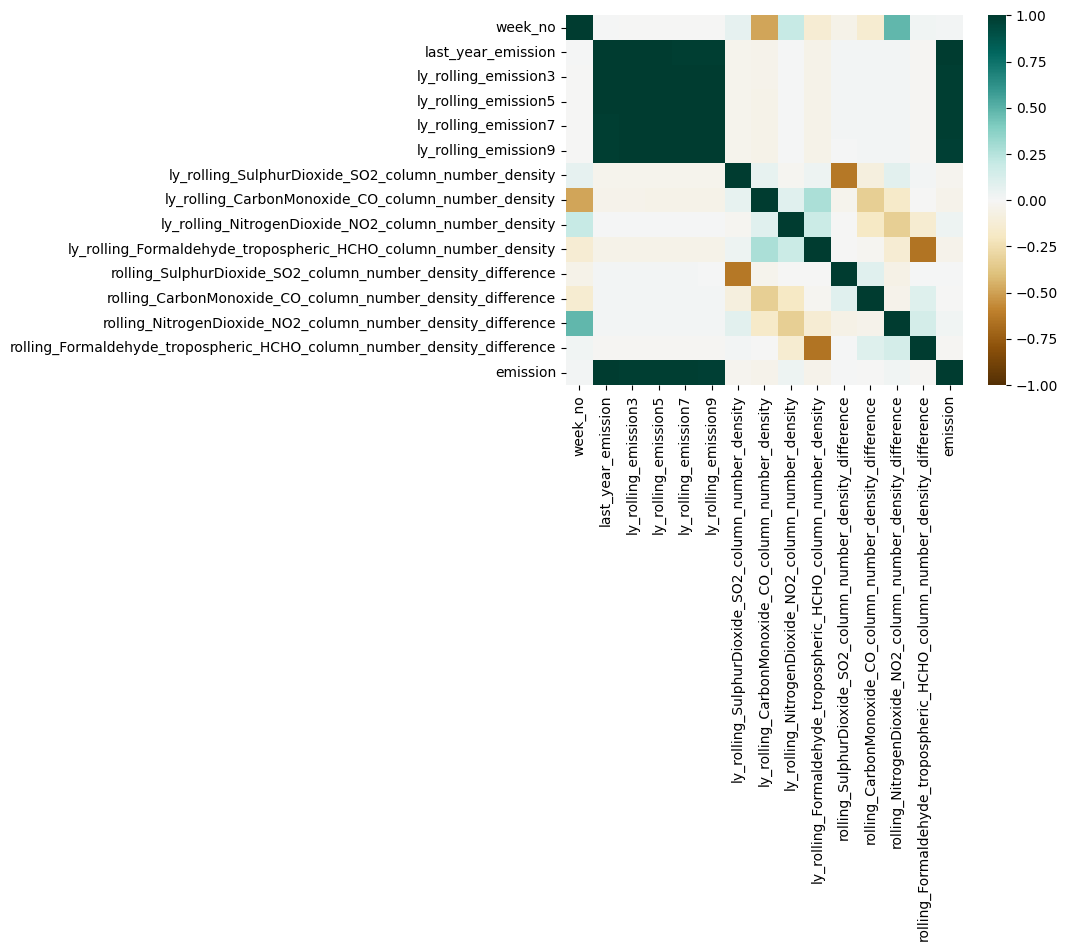

In [249]:
# Checking correlation matrix
corr_matrix = df_new_features.corr(numeric_only=True)
sn.heatmap(corr_matrix, vmin = -1, vmax = 1, cmap = 'BrBG')
plt.show()

Previous year carbon emissions data seems to be the only valuable information in making a prediction

#### Fitting a Model

After much trial and error, the following features had the best results, even though there doesn't appear to be much correlation between SO2, CO, NO2, HCHO and CO2 emissions.

In [250]:
# Selecting features for the model
df_select_features = df_new_features.loc[:, ['week_no'
                                            , 'last_year_emission'
                                            , 'ly_rolling_emission3'
                                            , 'ly_rolling_emission5'
                                            , 'ly_rolling_emission7'
                                            , 'ly_rolling_emission9'
                                            , 'ly_rolling_SulphurDioxide_SO2_column_number_density'
                                            , 'ly_rolling_CarbonMonoxide_CO_column_number_density'
                                            , 'ly_rolling_NitrogenDioxide_NO2_column_number_density'
                                            , 'ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density'
                                            , 'emission']]


Mean Squared Error: 803.6463029998284
SD Error:  5.388168926163727


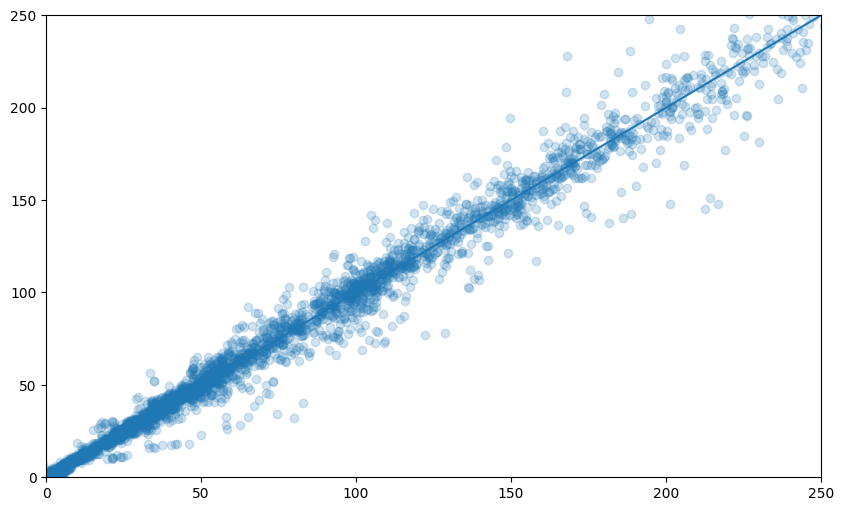

[1.2359910e-03 9.7823060e-01 8.2333628e-03 2.2667972e-03 1.1367172e-03
 3.8935896e-03 5.2580022e-04 1.5503211e-03 2.5006311e-03 4.2624812e-04]


In [251]:
x_train, x_test, y_train, y_test = train_test_split(df_select_features.drop(columns = ['emission']), df_select_features.emission, test_size = .2)
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .2)
plt.axline((0, 0), slope=1)
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()
print(model.feature_importances_)

#### Hyper Parameter Tuning

In [252]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_model = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
x_train, x_test, y_train, y_test = train_test_split(df_select_features.drop(columns = ['emission']), df_select_features.emission, test_size = .2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


Mean Squared Error: 37.5613388273273
SD Error:  3.330605264929152


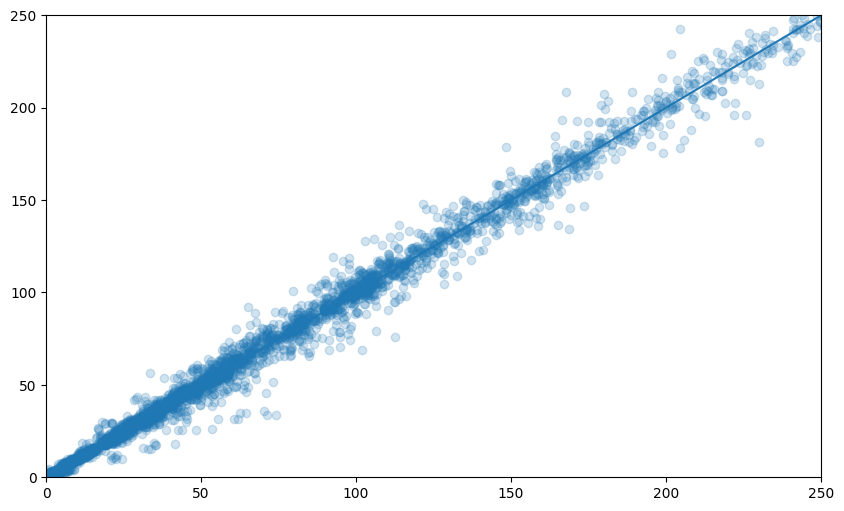

[1.2359910e-03 9.7823060e-01 8.2333628e-03 2.2667972e-03 1.1367172e-03
 3.8935896e-03 5.2580022e-04 1.5503211e-03 2.5006311e-03 4.2624812e-04]


In [255]:
x_train, x_test, y_train, y_test = train_test_split(df_select_features.drop(columns = ['emission']), df_select_features.emission, test_size = .2)
best_model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .2)
plt.axline((0, 0), slope=1)
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()
print(model.feature_importances_)